#### **Problem 0**
Access the CSMAR database and download the following data: 

Ⅰ Monthly Market Risk Premium Factor (Weighted Average Value of Negotiable Shares), Book-to-Market Ratio Factor (Weighted Average Value of Negotiable Shares) over December 2000 to December 2024 from the Factor Research Series/FamaFrench Factors table.

Ⅱ Monthly Market Value of Tradable Shares, Return Without Cash Dividend Reinvested and Market Type over December 2000 to December 2024 from the China Stock Market Series/Stock Trading table.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

factor = pd.read_csv("STK_MKT_THRFACMONTH.csv")
trade = pd.read_csv("TRD_Mnth.csv")
factor.columns = ["type", "date", "r_premium", "bm_ratio"]
factor = factor[factor["type"] == "P9706"]
factor = factor.drop(columns = "type")
trade.columns = ["code", "date", "mkt_value", "return", "type"]
trade = trade[trade["type"].isin([1, 4])]

#### **Problem 1**
Focus on A-share mainboard stocks listed on SZSE and SSE. For each month from January 2001 to December 2024, sort firms based on their last-month market capitalization and divide firms into ten groups according to last-month market capitalization deciles. By holding all stocks within each group with equal weights and rebalancing positions monthly, construct ten portfolios. Calculate the monthly returns for each of the ten portfolios from January 2001 to December 2024 and for each portfolio report results for the following regression:

$$
Portfolio\,Return_{i,t} = \alpha + \beta_1 Market\,Risk_t + \beta_2 BM\,Ratio_t + \epsilon_i
$$

   portfolio    return
0          1  0.027605
1          2  0.017629
2          3  0.014566
3          4  0.011945
4          5  0.009656
5          6  0.008636
6          7  0.008297
7          8  0.007295
8          9  0.007245
9         10  0.006978


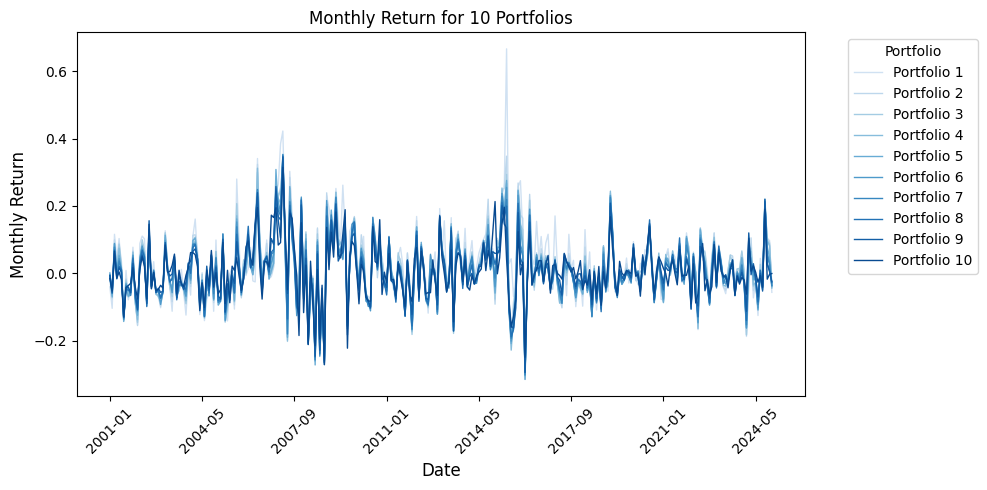

In [2]:
trade["mkt_value"] = trade.groupby("code")["mkt_value"].shift(1)
trade = trade.dropna(subset = "mkt_value")

portfolio_return = pd.DataFrame()

for month, month_data in trade.groupby("date"):
    month_data["portfolio"] = pd.qcut(month_data["mkt_value"], q = 10, labels = False) + 1
    portfolio_avg_return = month_data.groupby("portfolio")["return"].mean().reset_index()
    portfolio_avg_return["date"] = month
    portfolio_return = pd.concat([portfolio_return, portfolio_avg_return])

_portfolio_return = portfolio_return.groupby("portfolio")["return"].mean().reset_index()
print(_portfolio_return)

portfolio_pivot = portfolio_return.pivot(index = "date", columns  = "portfolio", values = "return")

plt.figure(figsize = (10, 5)) 
colors = plt.cm.Blues(np.linspace(0.2, 0.9, 10))  

for portfolio in range(1, 11):
    plt.plot(
        portfolio_pivot.index, 
        portfolio_pivot[portfolio], 
        label = f"Portfolio {portfolio}",
        linewidth = 1,
        color = colors[portfolio-1],  
    )

plt.xlabel("Date", fontsize = 12)
plt.ylabel("Monthly Return", fontsize=12)
plt.title("Monthly Return for 10 Portfolios", fontsize = 12)
plt.legend(title = "Portfolio", bbox_to_anchor = (1.05, 1), loc = "upper left", fontsize = 10) 
plt.xticks(rotation = 45) 
ax = plt.gca()  
ax.xaxis.set_major_locator(plt.MaxNLocator(10))  
plt.tight_layout() 

plt.show()

In [3]:
def run_regression(group):
    X = group[["r_premium", "bm_ratio"]]
    X = sm.add_constant(X)  
    y = group["return"]
    model = sm.OLS(y, X).fit()

    return pd.Series({
        "const_coef": model.params["const"],
        "r_premium_coef": model.params["r_premium"],
        "bm_ratio_coef": model.params["bm_ratio"],
        "r_premium_pval": model.pvalues["r_premium"],
        "bm_ratio_pval": model.pvalues["bm_ratio"],
        "rsquared": model.rsquared,
        "obs": model.nobs
    })

merged_df = pd.merge(portfolio_return, factor, how = "left", on = "date")
reg_result = merged_df.groupby("portfolio").apply(run_regression, include_groups = False)
print(reg_result)

           const_coef  r_premium_coef  bm_ratio_coef  r_premium_pval  \
portfolio                                                              
1            0.024999        1.021180      -1.099825    2.543140e-47   
2            0.014611        1.027325      -0.923232    8.733792e-66   
3            0.011339        1.032951      -0.838866    1.111706e-72   
4            0.008417        1.056721      -0.753507    2.141405e-80   
5            0.006160        1.038278      -0.726783    3.883456e-81   
6            0.005104        1.041816      -0.718278    6.129859e-90   
7            0.004436        1.060461      -0.608464   1.595074e-100   
8            0.003342        1.054049      -0.551549   1.407912e-112   
9            0.003033        1.048308      -0.418702   5.752554e-128   
10           0.001923        1.050693      -0.034608   1.874483e-186   

           bm_ratio_pval  rsquared    obs  
portfolio                                  
1           7.194884e-16  0.599018  288.0  
2  